In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = sp500_tickers['Symbol'].tolist()

# Get 10 random tickers
securities = pd.Series(sp500_tickers).sample(10, replace=False, random_state=435).tolist()
print(securities)

# Define the time period for historical data
start_date = '2010-01-01'
end_date = '2018-01-01'

# Fetch historical data for each security
historical_data = yf.download(securities, start=start_date, end=end_date, interval='1wk')

# Extract the adjusted closing prices
closing_prices = historical_data['Adj Close']

relative_returns = closing_prices.pct_change().dropna()
relative_returns_to_start = (1 + relative_returns).cumprod() - 1

mean_pct_change = relative_returns.mean().to_numpy()

# Compute the covariance matrix of relative returns
covariance_matrix = relative_returns.cov().to_numpy()


['SO', 'JCI', 'ETSY', 'BX', 'ETN', 'EW', 'ZION', 'RF', 'INVH', 'SLB']
[*********************100%%**********************]  10 of 10 completed


In [3]:
import numpy as np
from scipy.optimize import minimize

def mean_variance_optimization(mean_returns, cov_matrix, min_return, rand_val=50):
    num_assets = len(mean_returns)

    def objective(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - min_return}
    )

    bounds = tuple((0, 1) for asset in range(num_assets))
    #bounds = None

    initial_weights = np.ones(num_assets) / num_assets
    best_result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    for i in range(rand_val):
        initial_weights2 = np.random.dirichlet(np.ones(num_assets), size=1)[0]
        result = minimize(objective, initial_weights2, bounds=bounds, constraints=constraints)
        if(result.fun < best_result.fun): 
            best_result = result

    optimized_weights = best_result.x
    portfolio_return = np.dot(optimized_weights, mean_returns)
    portfolio_variance = best_result.fun

    return optimized_weights, portfolio_return, portfolio_variance

def generate_efficient_frontier(mean_returns, cov_matrix, num_points=200):
    target_returns = np.linspace(min(mean_returns), max(mean_returns), num_points)
    portfolio_variances = []

    for target_return in target_returns:
        _, _, portfolio_variance = mean_variance_optimization(mean_returns, cov_matrix, target_return)
        portfolio_variances.append(portfolio_variance)

    return np.sqrt(portfolio_variances), target_returns

def plot_efficient_frontier(mean_returns, cov_matrix, num_points=200):
    volatility, returns = generate_efficient_frontier(mean_returns, cov_matrix, num_points)

    plt.figure(figsize=(10, 6))
    start_ind = np.argmin(volatility)
    plt.plot(volatility[start_ind:]*np.sqrt(52), (1 + returns[start_ind:])**52 - 1, label='Efficient Frontier', color='blue')
    
    
    for i in range(len(mean_returns)):
        # Individual stock points corrected
        plt.scatter(np.sqrt(cov_matrix[i, i] * 52), (1 + mean_returns[i])**52 - 1, label=securities[i], marker='o')

    plt.title('Efficient Frontier with Individual Stocks')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylim(0, 0.5)
    plt.xlim(0, 0.35)
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
mean_returns = mean_pct_change
cov_matrix = covariance_matrix
num_points = 200

volatility, returns = generate_efficient_frontier(mean_returns, cov_matrix, num_points)

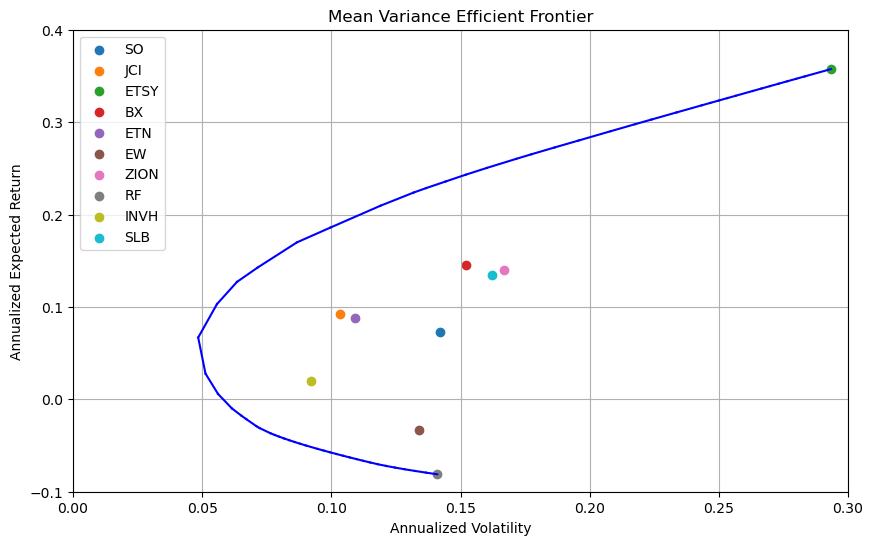

In [10]:
from scipy.spatial import ConvexHull
plt.figure(figsize=(10, 6))
start_ind = np.argmin(volatility)

hull = ConvexHull(np.stack((volatility, returns)).T)


# Plot convex hull
for simplex in hull.simplices[1:]:

    plt.plot(np.asarray(volatility*np.sqrt(52))[simplex], np.asarray((1 + returns)**52 - 1)[simplex], 'blue')

    
for i in range(len(securities)):
    # Individual stock points corrected
    plt.scatter(np.sqrt(cov_matrix[i, i] * 52), (1 + mean_pct_change[i])**52 - 1, label=securities[i], marker='o')

plt.title('Mean Variance Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylim(-0.1, 0.4)
plt.xlim(0, 0.3)
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def entropy_optimization(returns, return_constraint, rand_val=500):

    h = 0.01

    num_assets = returns.shape[1]
    min_return = np.min(returns)
    max_return = np.max(returns)

    buckets = int(max_return/h) - int(min_return/h) + 1

    mean_returns = np.mean(returns, axis = 0)


    def objective(weights):

        weighted_returns = np.matmul(returns, weights)
        probs, _ = np.histogram(weighted_returns, buckets, range=(int(min_return/h)*h, int(max_return/h)*h + h), density=True)
        probs = probs*h
        return -np.dot(probs, np.nan_to_num(np.log(probs), neginf=0).T)

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - return_constraint}
    )

    
    bounds = tuple((0, 1) for asset in range(num_assets))
    #bounds = None

    initial_weights = np.ones(num_assets) / num_assets

    if return_constraint > (1 + 0.15)**(1/52) - 1:
        initial_weights = np.zeros(num_assets)
        initial_weights[np.argmax(mean_returns)] = 1

    best_result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    for i in range(rand_val):
        initial_weights2 = 0.5 * best_result.x + 0.5*np.random.dirichlet(np.ones(num_assets), size=1)[0]
        result = minimize(objective, initial_weights2, bounds=bounds, constraints=constraints)
        if(result.fun < best_result.fun): 
            best_result = result

    optimized_weights = best_result.x
    portfolio_return = np.dot(optimized_weights, mean_returns)
    portfolio_entropy = best_result.fun

    return optimized_weights, portfolio_return, portfolio_entropy

def generate_entropy_frontier(returns, num_points=50):

    mean_returns = np.mean(returns, axis=0)

    
    target_returns = np.linspace(min(mean_returns), max(mean_returns), num_points)
    portfolio_entropies = []
    i = 0
    for target_return in target_returns:
        i += 1
        _, _, portfolio_entropy = entropy_optimization(returns, target_return)
        portfolio_entropies.append(portfolio_entropy)

    return portfolio_entropies, target_returns

def plot_entropy_frontier(returns, num_points=50):
    portfolio_entropies, portfolio_returns = generate_entropy_frontier(returns, num_points)

    plt.figure(figsize=(10, 6))
    start_ind = np.argmin(portfolio_entropies)
    plt.plot(portfolio_entropies[start_ind:], (portfolio_returns[start_ind:] + 1)**52 - 1, label='Efficient Frontier', color='blue')
    
    h = 0.01
    min_return = np.min(returns)
    max_return = np.max(returns)

    buckets = int(max_return/h) - int(min_return/h) + 1
    mean_returns = np.mean(returns, axis = 0)
    
    for i in range(returns.shape[1]):
        # Individual stock points corrected
        probs, _ = np.histogram(returns[:, i], buckets, range=(int(min_return/h)*h, int(max_return/h)*h + h), density=True)
        probs = probs*h
        plt.scatter(-np.dot(probs, np.nan_to_num(np.log(probs), neginf=0).T) , (1 + mean_returns[i])**52 - 1, label=securities[i], marker='o')

    plt.title('Efficient Frontier with Individual Stocks')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
returns = relative_returns.to_numpy()
num_points = 20

portfolio_entropies, portfolio_returns = generate_entropy_frontier(returns, num_points)

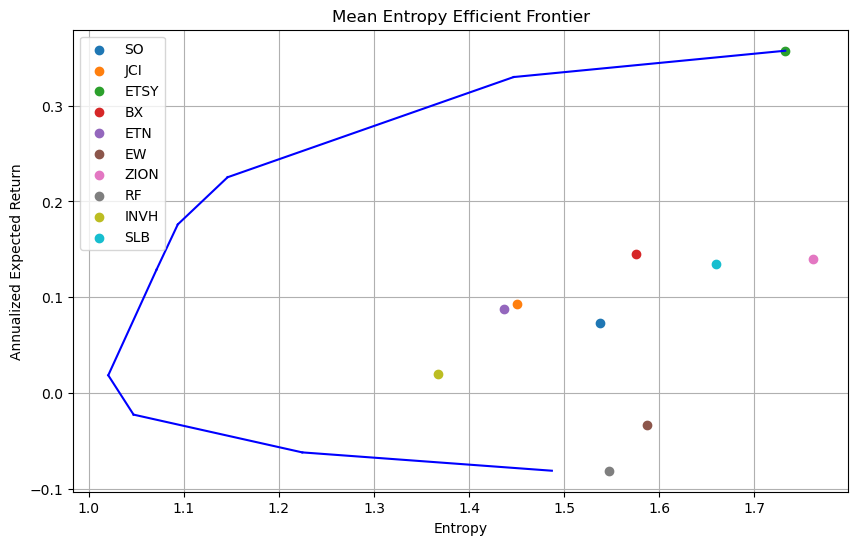

In [14]:
plt.figure(figsize=(10, 6))
#start_ind = np.argmin(portfolio_entropies)
#start_ind = 0
#plt.plot(portfolio_entropies[start_ind:], (1 + portfolio_returns[start_ind:])**52 - 1, label='Efficient Frontier', color='blue')

hull = ConvexHull(np.stack((portfolio_entropies, portfolio_returns)).T)


# Plot convex hull
for simplex in hull.simplices[1:]:

    plt.plot(np.asarray(portfolio_entropies)[simplex], np.asarray((1 + portfolio_returns)**52 - 1)[simplex], 'blue')
    
h = 0.01
min_return = np.min(returns)
max_return = np.max(returns)

buckets = int(max_return/h) - int(min_return/h) + 1
mean_returns = np.mean(returns, axis = 0)
    
for i in range(returns.shape[1]):
    # Individual stock points corrected
    probs, _ = np.histogram(returns[:, i], buckets, range=(int(min_return/h)*h, int(max_return/h)*h + h), density=True)
    probs = probs*h
    plt.scatter(-np.dot(probs, np.nan_to_num(np.log(probs), neginf=0).T) , (1 + mean_returns[i])**52 - 1, label=securities[i], marker='o')

plt.title('Mean Entropy Efficient Frontier')
plt.xlabel('Entropy')
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  10 of 10 completed


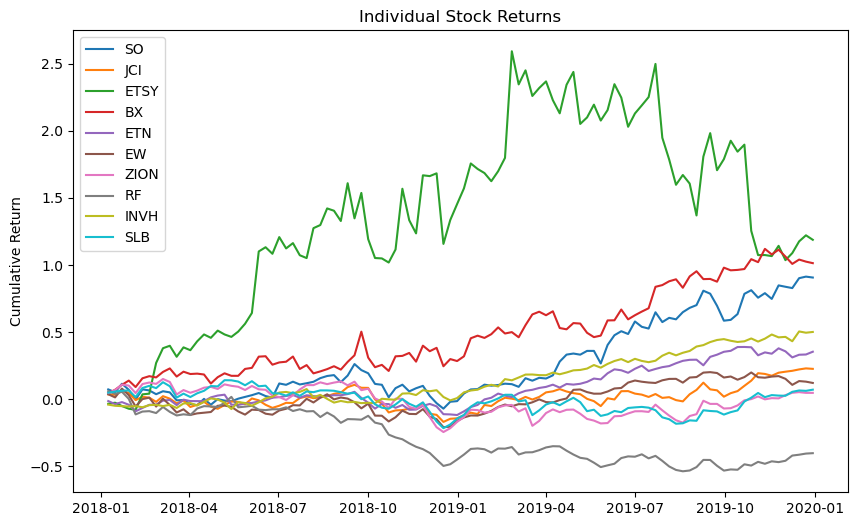

In [25]:
start_date = '2018-01-01'
end_date = '2020-01-01'

# Fetch historical data for each security
test_historical_data = yf.download(securities, start=start_date, end=end_date, interval='1wk')

# Extract the adjusted closing prices
test_closing_prices = test_historical_data['Adj Close']

test_relative_returns = test_closing_prices.pct_change().dropna()
test_relative_returns_to_start = (1 + test_relative_returns).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(test_relative_returns_to_start)
plt.title('Individual Stock Returns')
plt.ylabel('Cumulative Return')
plt.legend(securities)
plt.show()

[0.09961813 0.11485166 0.17503939 0.27787587 0.22560852 0.
 0.07567319 0.         0.01551006 0.01582318]
[0.03333636 0.09467889 0.05046212 0.21745802 0.07080914 0.03863727
 0.10123699 0.05870449 0.25986179 0.07481493]


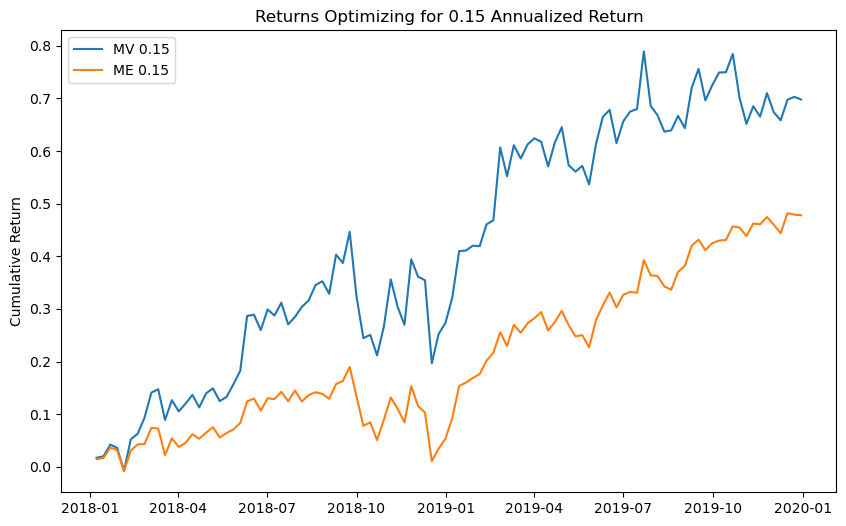

In [26]:
target_return = (1 + np.asarray(0.15))**(1/52) - 1

plt.figure(figsize=(10, 6))
mvw, _, _ = mean_variance_optimization(mean_pct_change, covariance_matrix, target_return, rand_val=100)
ew, _, _ = entropy_optimization(returns, target_return, rand_val=100)


plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), mvw), label=f'MV 0.15')
plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), ew), label=f'ME 0.15')

print(mvw)
print(ew)


plt.title('Returns Optimizing for 0.15 Annualized Return')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

[0.01058282 0.10014988 0.07552507 0.13260049 0.19301321 0.05307869
 0.16757931 0.01572851 0.20917165 0.04257037]
[0.06465765 0.18902221 0.0935847  0.13857123 0.1095938  0.00697467
 0.07095612 0.03700767 0.23652772 0.05310422]


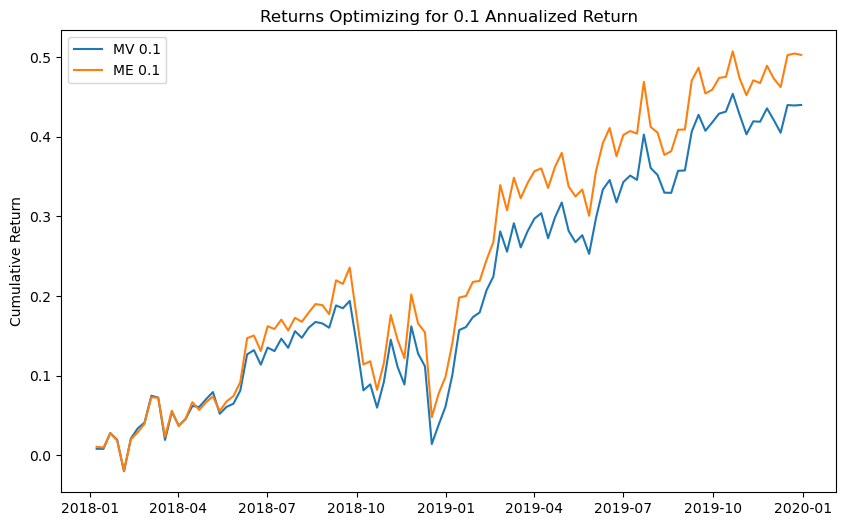

In [27]:
target_return = (1 + np.asarray(0.1))**(1/52) - 1

plt.figure(figsize=(10, 6))
mvw, _, _ = mean_variance_optimization(mean_pct_change, covariance_matrix, target_return, rand_val=100)
ew, _, _ = entropy_optimization(returns, target_return, rand_val=100)


plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), mvw), label=f'MV 0.1')
plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), ew), label=f'ME 0.1')

print(mvw)
print(ew)


plt.title('Returns Optimizing for 0.1 Annualized Return')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

[0.00000000e+00 3.43504641e-02 3.15129225e-01 3.57724495e-01
 7.83894567e-02 2.77555756e-17 1.34436063e-01 0.00000000e+00
 2.42861287e-17 7.99702955e-02]
[0.06074409 0.1636631  0.20453196 0.22136735 0.15464966 0.02112178
 0.10739553 0.01313263 0.01500862 0.03838529]


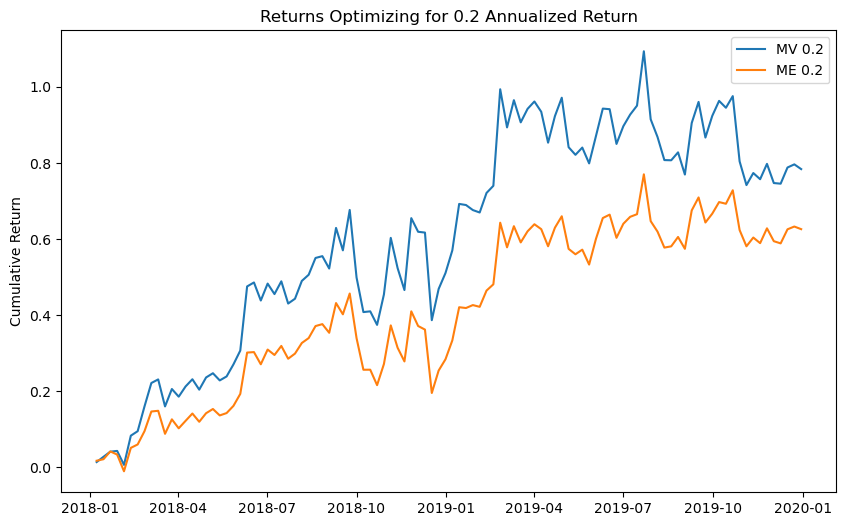

In [28]:
target_return = (1 + np.asarray(0.2))**(1/52) - 1

plt.figure(figsize=(10, 6))
mvw, _, _ = mean_variance_optimization(mean_pct_change, covariance_matrix, target_return, rand_val=100)
ew, _, _ = entropy_optimization(returns, target_return, rand_val=100)


plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), mvw), label=f'MV 0.2')
plt.plot(test_historical_data.index[1:], np.matmul(test_relative_returns_to_start.to_numpy(), ew), label=f'ME 0.2')

print(mvw)
print(ew)


plt.title('Returns Optimizing for 0.2 Annualized Return')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()